# DASK FINAL

In [1]:
import dask
from dask.distributed import Client, progress, LocalCluster
client = Client(n_workers=1)
client.restart()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 7.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53620,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.83 GiB
Comm: tcp://127.0.0.1:53647,Total threads: 8
Dashboard: http://127.0.0.1:53648/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:53623,


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
# from sklearn.metrics import accuracy_score
# from dask_ml.metrics import accuracy_score

In [3]:
%%time

# client = Client(asynchronous=True, n_workers=4, threads_per_worker=2)

import dask.dataframe as dd

# Subset of the columns to use
cols = ['ActualElapsedTime', 'CRSElapsedTime', 'Distance','AirTime','ArrDelay',
        'DepDelay', 'CRSDepTime', 'CRSArrTime', 'CarrierDelay', 'LateAircraftDelay','Origin', 'Dest','UniqueCarrier']


# Create the dataframe
df = dd.read_csv('DelayedFlights.csv', usecols=cols, storage_options={'anon': True},dtype={'Distance': 'float64','CRSArrTime': 'float64',
       'CRSDepTime': 'float64'},assume_missing=True)

df = df.dropna()

df = df.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

is_delayed = (df.DepDelay.fillna(16) > 15)  # column of labels
del df['DepDelay']  # Remove delay information from training dataframe

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
df['CRSArrTime'] = df['CRSArrTime'].clip(upper=2399)


Wall time: 1.15 s


In [4]:
df.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
513384,1140.0,1345.0,NW,262.0,245.0,240.0,72.0,MSP,SFO,1589.0,49.0,6.0
338409,1725.0,1845.0,AA,205.0,200.0,180.0,50.0,DFW,LAX,1235.0,45.0,0.0
531066,1700.0,1805.0,AA,50.0,65.0,33.0,42.0,AUS,DFW,190.0,42.0,0.0
365389,1725.0,2008.0,CO,265.0,283.0,240.0,16.0,IAH,SEA,1874.0,3.0,13.0
422777,750.0,922.0,XE,140.0,92.0,81.0,98.0,CLE,PHL,363.0,0.0,0.0


In [5]:
%%time
df2 = dd.get_dummies(df.categorize()).persist()

Wall time: 5.85 s


In [6]:
df2.head()

,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Distance,CarrierDelay,LateAircraftDelay,UniqueCarrier_NW,...,Dest_INL,Dest_ADK,Dest_GST,Dest_AKN,Dest_LWB,Dest_ALO,Dest_ITH,Dest_PIR,Dest_HTS,Dest_WYS
513384,1140.0,1345.0,262.0,245.0,240.0,72.0,1589.0,49.0,6.0,1,...,0,0,0,0,0,0,0,0,0,0
338409,1725.0,1845.0,205.0,200.0,180.0,50.0,1235.0,45.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
531066,1700.0,1805.0,50.0,65.0,33.0,42.0,190.0,42.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
365389,1725.0,2008.0,265.0,283.0,240.0,16.0,1874.0,3.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
422777,750.0,922.0,140.0,92.0,81.0,98.0,363.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
is_delayed.head()

513384    True
338409    True
531066    True
365389    True
422777    True
Name: DepDelay, dtype: bool

In [8]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, CRSDepTime to LateAircraftDelay
dtypes: object(3), float64(9)

In [9]:
X = df2
y = is_delayed

In [10]:
%%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)


data_train, data_test = X.random_split([0.9, 0.1], random_state=0)
labels_train, labels_test = y.random_split([0.9, 0.1], random_state=0)

Wall time: 151 ms


In [11]:
%%time
# from xgboost import XGBClassifier


import dask_xgboost as dxgb

param = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3,
#     # 'silent': 0, 
#     'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
# num_round = 200  # the number of training iterations



bst = dxgb.train(client, param, data_train, labels_train)

Wall time: 36.2 s


In [12]:
bst

In [13]:
# dask-xgboost is used to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [14]:
predictions.compute()

array([0.5477394 , 0.5477394 , 0.5476931 , ..., 0.5476931 , 0.52710754,
       0.5476931 ], dtype=float32)

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
print("ROC_AUC Score : ",roc_auc_score(labels_test.compute(), predictions.compute()))

ROC_AUC Score :  0.9930690158088374


In [16]:
import matplotlib.pyplot as plt

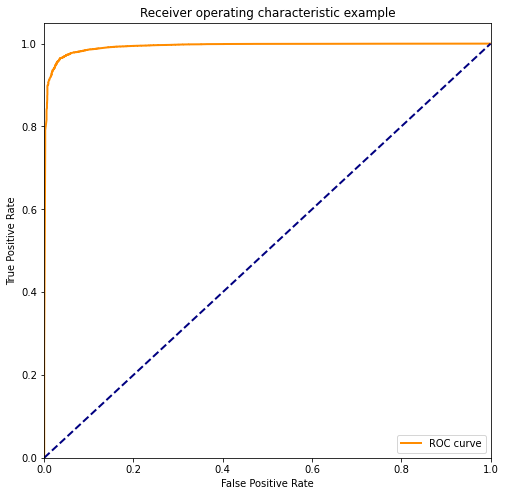

In [17]:
fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()